## Data preprocessing

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TreebankWordTokenizer
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import pandas as pd

In [4]:
# Load data
df_combined = pd.read_csv('/content/drive/MyDrive/02_labelled_data.csv')

# Initialize stop words and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

tokenizer = TreebankWordTokenizer()

def preprocess_lyrics(lyric):
    tokens = lyric.split()  # Simple split instead of word_tokenize
    tokens = [lemmatizer.lemmatize(word.lower()) for word in tokens if word.isalpha() and word.lower() not in stop_words]
    return ' '.join(tokens)


# Apply preprocessing function to the lyrics column
df_combined['processed_text'] = df_combined['lyrics'].apply(preprocess_lyrics)

# # Tokenize and pad sequences
max_words = 10000  # Vocabulary size
max_len = 100  # Maximum length of each sequence
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df_combined['processed_text'])
sequences = tokenizer.texts_to_sequences(df_combined['processed_text'])
X = pad_sequences(sequences, maxlen=max_len)

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Create a new column for encoded labels, so original data remains untouched
df_combined['label_encoded'] = label_encoder.fit_transform(df_combined['label'])

# Use this new column for training
labels = df_combined['label_encoded'].values

# Load GloVe embeddings
embedding_dim = 100
embedding_index = {}
glove_path = '/content/glove.6B.100d.txt'

with open(glove_path, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coef = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coef

# Create embedding matrix
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < max_words:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
labels = df_combined['label_encoded'].values

# Encode labels (if labels are strings, you may need LabelEncoder first)
label_map = {label: idx for idx, label in enumerate(np.unique(labels))}
labels = np.array([label_map[label] for label in labels])

y = labels

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_combined.to_csv('/content/drive/MyDrive/03_pre_text_data.csv')

#### CNN

In [9]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, Conv1D, GlobalMaxPooling1D, Input
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

In [10]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

# Define the model architecture
def create_optimized_model():
    input_layer = Input(shape=(max_len,))
    embedding_layer = Embedding(input_dim=max_words, output_dim=embedding_dim,
                                weights=[embedding_matrix], input_length=max_len, trainable=False)(input_layer)

    # Convolutional layers with increased filters and L2 regularization
    conv_3 = Conv1D(128, 3, activation='relu', kernel_regularizer=l2(0.001))(embedding_layer)
    conv_5 = Conv1D(128, 5, activation='relu', kernel_regularizer=l2(0.001))(embedding_layer)
    conv_7 = Conv1D(64, 7, activation='relu', kernel_regularizer=l2(0.001))(embedding_layer)

    # Global Max Pooling layers
    pool_3 = GlobalMaxPooling1D()(conv_3)
    pool_5 = GlobalMaxPooling1D()(conv_5)
    pool_7 = GlobalMaxPooling1D()(conv_7)

    # Concatenate pooling layers
    concat = tf.keras.layers.concatenate([pool_3, pool_5, pool_7])

    # Add dropout for regularization
    dropout = Dropout(0.5)(concat)

    # Fully connected dense layers
    dense_layer = Dense(64, activation='relu')(dropout)
    dropout = Dropout(0.5)(dense_layer)
    output_layer = Dense(len(np.unique(labels)), activation='softmax')(dropout)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

# Create and train the enhanced model
optimized_model = create_optimized_model()
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.00001)

history = optimized_model.fit(
    X_train, y_train,
    epochs=20,  # Allow more epochs to see long-term performance
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

#predict y using test data
y_pred_test= np.argmax(optimized_model.predict(X_test), axis=1)

#compute f1 score
f1= f1_score(y_test, y_pred_test, average='macro')


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - accuracy: 0.1794 - loss: 2.8624 - val_accuracy: 0.2735 - val_loss: 2.1298 - learning_rate: 5.0000e-04
Epoch 2/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - accuracy: 0.2103 - loss: 2.1820 - val_accuracy: 0.2332 - val_loss: 2.0311 - learning_rate: 5.0000e-04
Epoch 3/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.2570 - loss: 2.1661 - val_accuracy: 0.2493 - val_loss: 2.0101 - learning_rate: 5.0000e-04
Epoch 4/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - accuracy: 0.2468 - loss: 2.0910 - val_accuracy: 0.2654 - val_loss: 1.9957 - learning_rate: 5.0000e-04
Epoch 5/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - accuracy: 0.2448 - loss: 2.0492 - val_accuracy: 0.3217 - val_loss: 1.9793 - learning_rate: 5.0000e-04
Epoch 6/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.2904 - loss: 2.0047 - val_accuracy: 0.3164 - val_loss: 1.9464 - learning_rate: 5.0000e-04
Epoch 7/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.2731 

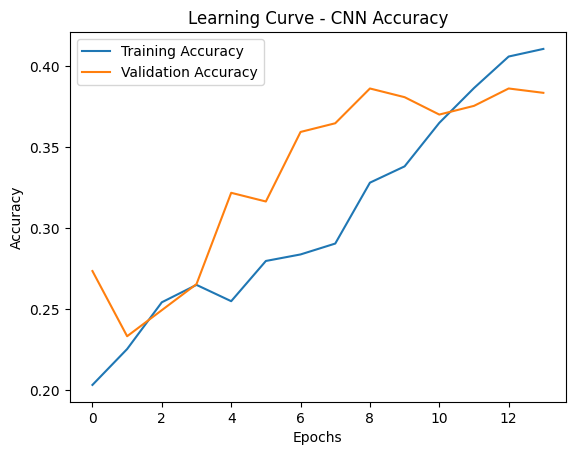

In [11]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

import matplotlib.pyplot as plt

plt.plot()
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Learning Curve - CNN Accuracy')
plt.legend()


In [12]:
print(f1)

0.19069126556155183


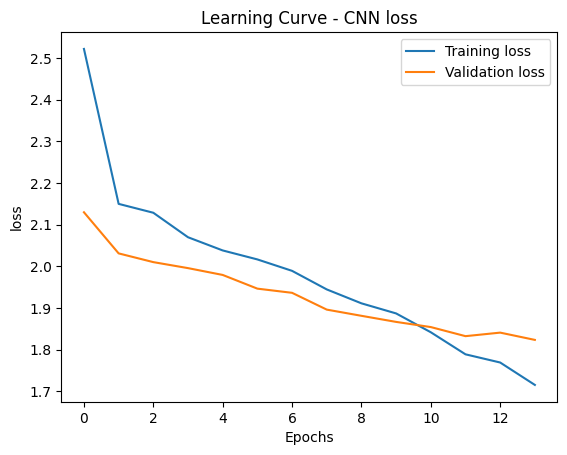

In [13]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

import matplotlib.pyplot as plt

plt.plot()
plt.plot(train_loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.title('Learning Curve - CNN loss')
plt.legend()

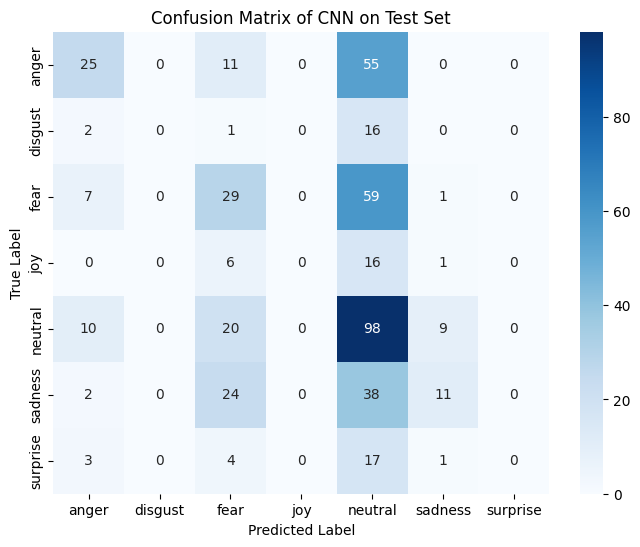

In [14]:
import seaborn as sns
# Compute confusion matrix
label_names = label_encoder.classes_  # Use original label names
confusion_mat = confusion_matrix(y_test, y_pred_test)

# Create a DataFrame for the confusion matrix for better visualization
confusion_df = pd.DataFrame(confusion_mat, index=label_names, columns=label_names)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_df, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix of CNN on Test Set")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [15]:
optimized_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 100)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 100, 100)       │      1,000,000 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_3 (Conv1D)         │ (None, 98, 128)        │         38,528 │ embedding_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_4 (Conv1D)         │ (None, 96, 128)        │         64,128 │ embedding_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_5 (Conv1D)         │ (None, 94, 64)         │         44,864 │ embedding_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d_3    │ (None, 128)            │              0 │ conv1d_3[0][0]         │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d_4    │ (None, 128)            │              0 │ conv1d_4[0][0]         │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d_5    │ (None, 64)             │              0 │ conv1d_5[0][0]         │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 320)            │              0 │ global_max_pooling1d_… │
│ (Concatenate)             │                        │                │ global_max_pooling1d_… │
│                           │                        │                │ global_max_pooling1d_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 320)            │              0 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 64)             │         20,544 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 64)             │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 7)              │            455 │ dropout_3[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,505,559 (5.74 MB)

 Trainable params: 168,519 (658.28 KB)

 Non-trainable params: 1,000,000 (3.81 MB)

 Optimizer params: 337,040 (1.29 MB)

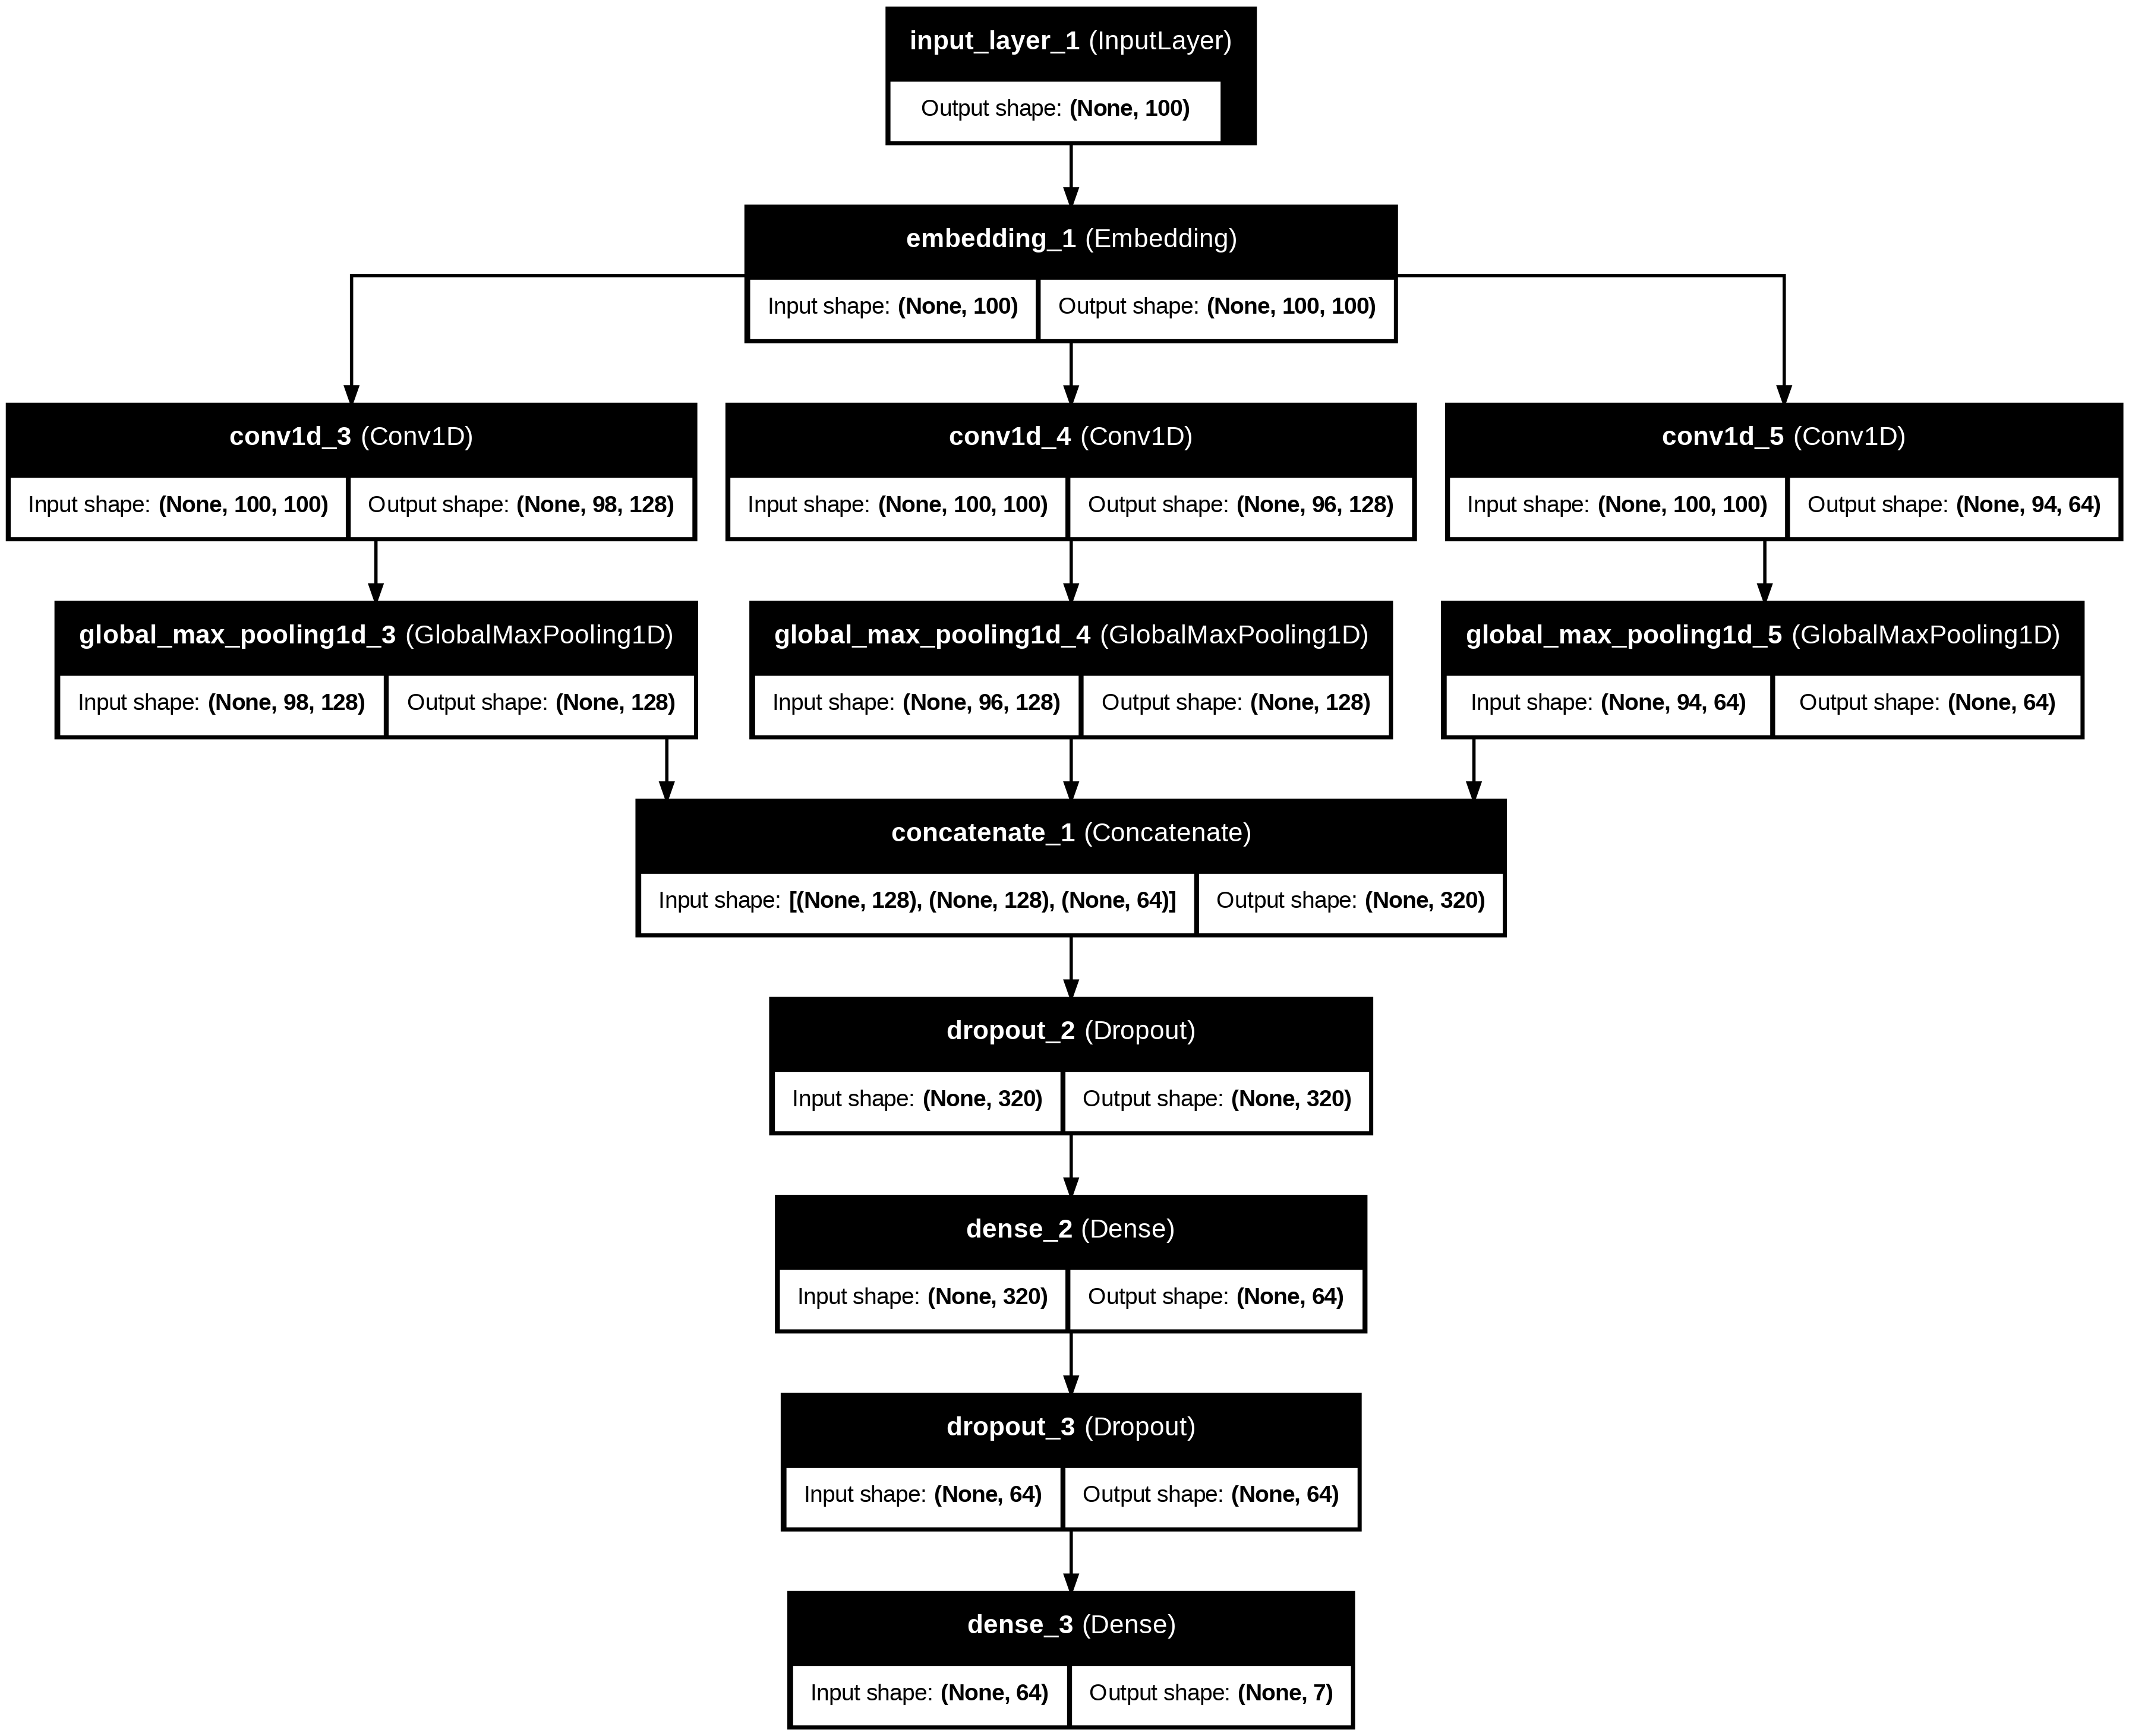

In [17]:
plot_model(optimized_model, show_shapes=True, show_layer_names=True)